In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15

import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import math

import sklearn
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.grid_search import GridSearchCV

Autosaving every 15 seconds


In [3]:
train_data = pd.read_csv('Data/train.csv')
train_data.describe()

,id,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_84,feat_85,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93
count,61878.000000,61878.00000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,...,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000,61878.000000
mean,30939.500000,0.38668,0.263066,0.901467,0.779081,0.071043,0.025696,0.193704,0.662433,1.011296,...,0.070752,0.532306,1.128576,0.393549,0.874915,0.457772,0.812421,0.264941,0.380119,0.126135
std,17862.784315,1.52533,1.252073,2.934818,2.788005,0.438902,0.215333,1.030102,2.255770,3.474822,...,1.151460,1.900438,2.681554,1.575455,2.115466,1.527385,4.597804,2.045646,0.982385,1.201720
min,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15470.250000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,30939.500000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,46408.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,61878.000000,61.00000,51.000000,64.000000,70.000000,19.000000,10.000000,38.000000,76.000000,43.000000,...,76.000000,55.000000,65.000000,67.000000,30.000000,61.000000,130.000000,52.000000,19.000000,87.000000


In [13]:
clf = RandomForestClassifier(n_estimators=400, max_depth=15, min_samples_split=12, min_samples_leaf=3, max_features=20)
rf_best_params = {"n_estimators": [450,500], 
                  "max_depth": [10,15,20], 
                  "min_samples_split": [6,13], 
                  "min_samples_leaf": [1,3],
                  "max_features": [20,30,40]}

In [5]:
train_data = train_data.drop("id", axis = 1)
def convert_target(x):
    return int(x["target"].split('_')[1])
train_data["target"] = train_data.apply(convert_target, axis = 1)

In [11]:
from sklearn.metrics import log_loss, accuracy_score
def test_method(method, a_train, a_test, b_train, b_test):
    print method.__class__
    method.fit(a_train, b_train)
    print log_loss(b_train, method.predict_proba(a_train))

def test_methods(methods, a_train, a_test, b_train, b_test):
    for method in methods:
        test_method(method, a_train, a_test, b_train, b_test)

def test_models(data):
    target = data.target
    train = data.drop('target', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.2, random_state = 42)
    methods = [RandomForestClassifier(n_estimators = 100)]
    test_methods(methods, X_train, X_test, y_train, y_test)

def get_best_params(method, params, data):
    target = data.target
    train = data.drop('target', axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.2, random_state = 42)
    errors_train, errors_test = aggregate_train_test_errors(method, params, X_train, y_train, X_test, y_test, [log_loss], print_flag=True)
    plot_train_test_errors(method, params, errors_train, errors_test)
    
def print_score(model, metric, X_train, y_train, X_test, y_test):
        print("Model: %s Metric: %s On test: %f" % (model.__class__.__name__, metric.__name__, metric(y_test, model.predict_proba(X_test))))
        
def print_scores(model, metrics, X_train, y_train, X_test, y_test, parameter = None):
    for metric in metrics:
        if parameter != None:
            print("%s %s" % (parameter[0], parameter[1]))
            print_score(model, metric, X_train, y_train, X_test, y_test)
        else:
            print_score(model, metric, X_train, y_train, X_test, y_test)
    
def aggregate_train_test_errors(model, params, X_train, y_train, X_test, y_test, metrics = [], print_flag = False):
    errors_train = {key: {'params': params[key], 'values': []} for key in params.keys()}
    errors_test = {key: {'params': params[key], 'values': []}  for key in params.keys()}
    base_parameters = model.get_params()
    for key, values in params.iteritems():
        if isinstance(values, list):
            for value in values:
                model.set_params(**{key: value})
                model.fit(X_train, y_train)
                errors_train[key]['values'].append(model.score(X_train, y_train))
                errors_test[key]['values'].append(model.score(X_test, y_test))
                if print_flag == True and metrics:
                    print_scores(model, metrics, X_train, y_train, X_test, y_test, (key, value))
            model.set_params(**base_parameters)
        else:
            raise Exception("Take only list of parameters!")   
    return errors_train, errors_test

def plot_train_test_errors(model, model_params, errors_train, errors_test, save = None):
    fig, axes = plt.subplots(ncols=len(model_params))
    fig.set_size_inches((15,9))
    for ind, param in enumerate(model_params.keys()):
        if isinstance(errors_train[param]['params'][0], str):
            axes[ind].plot(range(len(errors_train[param]['params'])), errors_train[param]['values'], label = 'on train')
            axes[ind].plot(range(len(errors_train[param]['params'])), errors_test[param]['values'], label = 'on test')
            axes[ind].xaxis.set_ticks(range(len(errors_train[param]['params'])), errors_train[param]['params'])
        else:            
            axes[ind].plot(errors_train[param]['params'], errors_train[param]['values'], label = 'on train')
            axes[ind].plot(errors_train[param]['params'], errors_test[param]['values'], label = 'on test')
            axes[ind].xaxis.set_ticks(range(len(errors_train[param]['params'])), errors_train[param]['params'])
        axes[ind].set_title(str(param))
    plt.legend()
    plt.tight_layout()

min_samples_leaf 1
Model: RandomForestClassifier Metric: log_loss On test: 1.492018
min_samples_leaf 2
Model: RandomForestClassifier Metric: log_loss On test: 0.838152
min_samples_leaf 3
Model: RandomForestClassifier Metric: log_loss On test: 0.749885
min_samples_leaf 4
Model: RandomForestClassifier Metric: log_loss On test: 0.715954
min_samples_leaf 5
Model: RandomForestClassifier Metric: log_loss On test: 0.689017
min_samples_leaf 6
Model: RandomForestClassifier Metric: log_loss On test: 0.700051
min_samples_leaf 7
Model: RandomForestClassifier Metric: log_loss On test: 0.721043
min_samples_leaf 8
Model: RandomForestClassifier Metric: log_loss On test: 0.715241
min_samples_leaf 9
Model: RandomForestClassifier Metric: log_loss On test: 0.714549
min_samples_leaf 10
Model: RandomForestClassifier Metric: log_loss On test: 0.711208
min_samples_leaf 11
Model: RandomForestClassifier Metric: log_loss On test: 0.713551
min_samples_leaf 12
Model: RandomForestClassifier Metric: log_loss On test

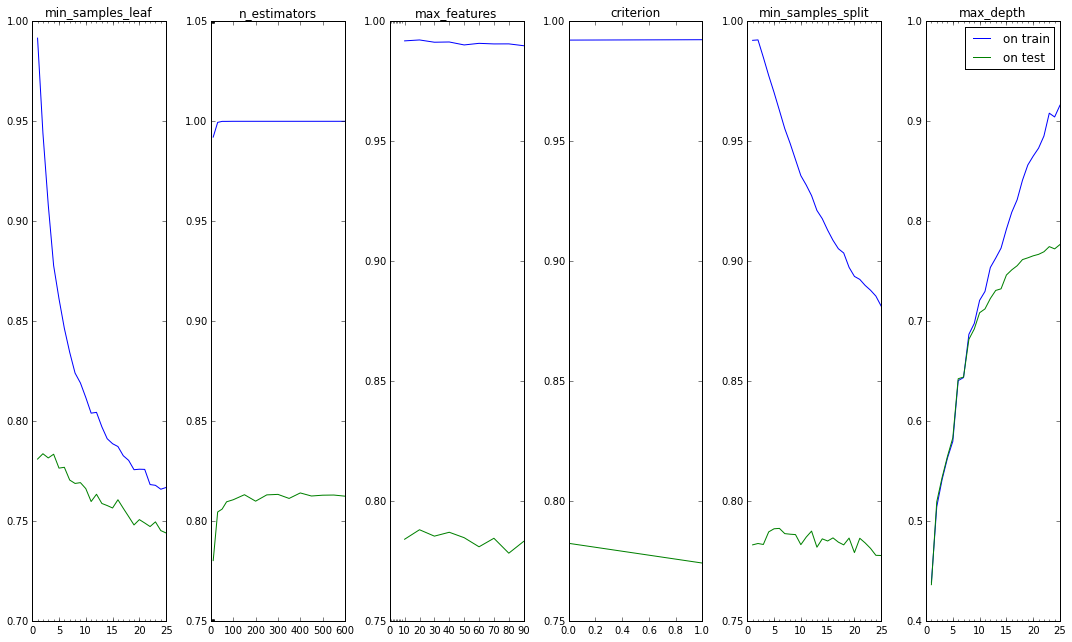

In [12]:
rf_params = {"n_estimators": [10,30,50,70,100,150,200,250,300,350,400,450,500,550,600], 
             "criterion": ["gini", "entropy"], 
             "max_depth": range(1,26), 
             "min_samples_split": range(1,26), 
             "min_samples_leaf": range(1,26), 
             "max_features": range(10, 100, 10)}

get_best_params(RandomForestClassifier(), rf_params, train_data)

In [14]:
target = train_data['target'].values
train = train_data.drop(['target'], axis = 1)
clf.fit(train, target)

RandomForestClassifier(bootstrap=True, compute_importances=None,
            criterion='gini', max_depth=15, max_features=20,
            max_leaf_nodes=None, min_density=None, min_samples_leaf=3,
            min_samples_split=12, n_estimators=400, n_jobs=1,
            oob_score=False, random_state=None, verbose=0)

In [15]:
test = pd.read_csv('Data/test.csv')

In [16]:
test = test.drop("id", axis = 1)

In [17]:
predicted = clf.predict_proba(test)

In [18]:
sub = pd.DataFrame(predicted, columns = ['Class_1','Class_2','Class_3','Class_4','Class_5','Class_6','Class_7','Class_8','Class_9'])

In [19]:
sub["id"] = list(range(1,len(sub.index) + 1))
sub.head()

,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,id
0,0.012757,0.200113,0.168381,0.506430,0.002155,0.040475,0.036695,0.018282,0.014711,1
1,0.017299,0.075085,0.044791,0.025353,0.011578,0.468503,0.025755,0.308211,0.023425,2
2,0.000676,0.000632,0.000295,0.000119,0.000039,0.981936,0.000906,0.012310,0.003088,3
3,0.008473,0.488550,0.321014,0.101603,0.001670,0.006261,0.014296,0.008507,0.049626,4
4,0.077588,0.020307,0.010702,0.004334,0.005317,0.046594,0.038436,0.352794,0.443928,5


In [20]:
cols = sub.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub = sub[cols]

In [21]:
sub.head()

,id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9
0,1,0.012757,0.200113,0.168381,0.506430,0.002155,0.040475,0.036695,0.018282,0.014711
1,2,0.017299,0.075085,0.044791,0.025353,0.011578,0.468503,0.025755,0.308211,0.023425
2,3,0.000676,0.000632,0.000295,0.000119,0.000039,0.981936,0.000906,0.012310,0.003088
3,4,0.008473,0.488550,0.321014,0.101603,0.001670,0.006261,0.014296,0.008507,0.049626
4,5,0.077588,0.020307,0.010702,0.004334,0.005317,0.046594,0.038436,0.352794,0.443928


In [22]:
sub.to_csv('Data/submission.csv', index = False)

In [119]:
test_models(train_data)

<class 'sklearn.ensemble.forest.RandomForestClassifier'>
0.863422722149


In [131]:
rf_params = {"n_estimators": [10,50,100,250,400,550,700], 
             "criterion": ["gini", "entropy"], 
             "max_depth": range(1, 26, 2), 
             "min_samples_split": range(1, 26, 2), 
             "min_samples_leaf": range(1, 26, 2), 
             "max_features": range(10, 100, 10)}

In [133]:
test_models(train_data)

min_samples_leaf 1
Model: RandomForestClassifier Metric: log_loss On test: 1.496499
min_samples_leaf 3
Model: RandomForestClassifier Metric: log_loss On test: 0.745206
min_samples_leaf 5
Model: RandomForestClassifier Metric: log_loss On test: 0.710818
min_samples_leaf 7
Model: RandomForestClassifier Metric: log_loss On test: 0.712698
min_samples_leaf 9
Model: RandomForestClassifier Metric: log_loss On test: 0.721043
min_samples_leaf 11
Model: RandomForestClassifier Metric: log_loss On test: 0.722068
min_samples_leaf 13
Model: RandomForestClassifier Metric: log_loss On test: 0.735181
min_samples_leaf 15
Model: RandomForestClassifier Metric: log_loss On test: 0.736141
min_samples_leaf 17
Model: RandomForestClassifier Metric: log_loss On test: 0.746468
min_samples_leaf 19
Model: RandomForestClassifier Metric: log_loss On test: 0.756331
min_samples_leaf 21
Model: RandomForestClassifier Metric: log_loss On test: 0.750878
min_samples_leaf 23
Model: RandomForestClassifier Metric: log_loss On 

KeyboardInterrupt: 